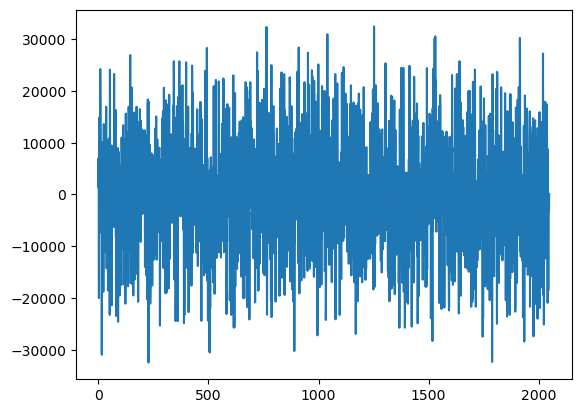

In [236]:
wave = np.fromfile('calibrator_231001.bin' ,dtype=np.int16)
plt.plot(wave)
sampling_rate=102.4e6

In [237]:
Ns = len(wave) # basic waveform length
Nx = 16 # number of repetitions we want to generate
Npt = Ns * Nx # total length

In [238]:
# first way of doing it, is simply stacking the waveforms 8 times
wave_total_1 = np.hstack((wave,)*Nx)
print(wave_total_1)
print(len(wave_total_1))
assert(wave_total_1.shape == (Npt,))

[ 1456  6990   570 ... -2435 -3351   117]
32768


In [239]:
# Now we are going to do the same in very complicated way, that will enable us to instute time delays without interpolations
# First we will transform the waveform into Fourier space and then generate the extended waveforms using "tones"

wave_f = np.fft.rfft(wave)
freqs = np.fft.rfftfreq(Ns)
phi = np.arange(Npt)*2*np.pi/Ns
wave_total_2 = np.zeros(Npt, dtype=complex)
for freq, comp in enumerate(wave_f):
    # add to wave_total_2 the component at frequency freq
    wave_total_2 += 2 * comp * np.exp(1j * phi * (freqs[freq] * Ns)) / Ns

wave_total_2 = np.real(wave_total_2)

float_formatter = "{:5.0f}".format
np.set_printoptions(formatter={'float_kind': float_formatter})  # format print for easier comparison
print(f"Stacked: \n\t{wave_total_1}")
print(f"FFT: \n\t{wave_total_2}")

# Check equality
difference = np.abs(wave_total_1 - wave_total_2)
print(f"\nMax difference:", np.max(difference))
print("Mean difference:", np.mean(difference))
print("Standard deviation of difference:", np.std(difference))

assert(np.allclose(wave_total_1, wave_total_2))


Stacked: 
	[ 1456  6990   570 ... -2435 -3351   117]
FFT: 
	[ 1456  6990   570 ... -2435 -3351   117]

Max difference: 2.5248937163269147e-07
Mean difference: 1.9604227559887055e-08
Standard deviation of difference: 2.293927268264866e-08


In [240]:
# Now turn the above into a function that can generate the waveform with arbirary clock drifts (f -> f*(1+clock_drift))

# Generate a large Nx waveform with Nx of 100000 or something.

# Write a function that pulls a single tone from this waveform using fft->pick up just coefficients aronud the frequency of interest --> fft back

# Use your previous code to fit the parameters of this tone, see if you can get the frequency and amplitude right

In [241]:
# part 1: function with adjustable clock drifts and Nx
# same process, small tweaks to meet new goals
def drifted_signal(clock_drift=0, nx=500):  # for nx different than original Nx=16
    signal_drift = np.zeros(Ns * nx, dtype=complex)
    phi_shift = np.arange(Ns * nx) * 2 * np.pi / Ns

    for f, coef in enumerate(wave_f):
        # add to drifted_wave the component at frequency f
        signal_drift += 2 * coef * np.exp(1j * phi_shift * f * (1 + clock_drift)) / Ns
    signal_drift = np.real(signal_drift)
    return signal_drift


# adjust as necessary, can easily be changed to respond to user input rather than a manually set value

signal_drifted = drifted_signal(2e-6)
signal_not_drifted = drifted_signal(0)




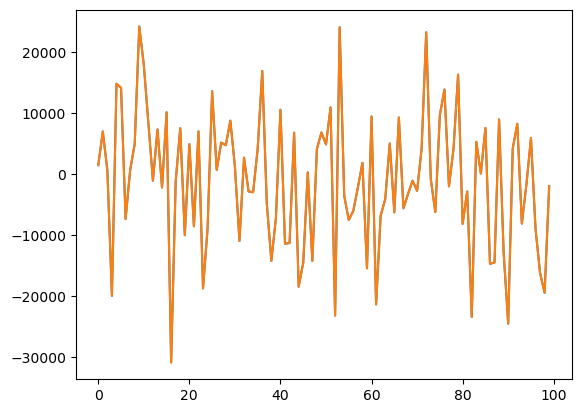

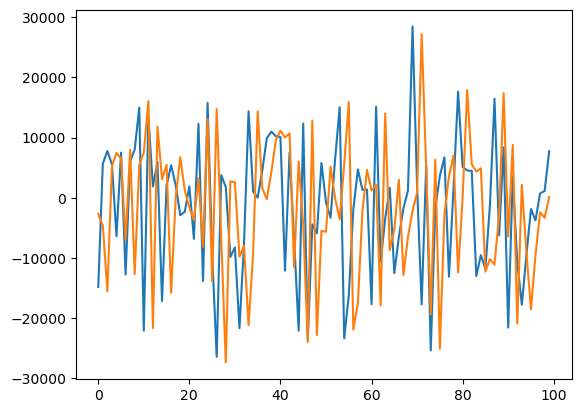

In [10]:
plt.figure()
plt.plot(signal_drifted[:100])
plt.plot(signal_not_drifted[:100])
plt.show()
plt.figure()
plt.plot(signal_drifted[-100:])
plt.plot(signal_not_drifted[-100:])
plt.show()

In [242]:
def get_peaks (signal, Nex=1, fbase=50e3, fstep=100e3, fmax=1e6, fdelta=30e3, sampling_rate=102.4e6):
    N = len(signal) 
    dt =  N*Nex/sampling_rate
    df = 1/dt
    window = np.hanning(N)
    signal_l = np.hstack( (signal*window, np.zeros(N*Nex-N)) )
    signal_f = np.fft.rfft(signal_l)
    freqs = []
    pwrs = []
    back = []
    while fbase < fmax:
        ndx = int(fbase/df)
        
        delta_ndx = int(fdelta/df)
        slice = np.abs(signal_f[ndx-delta_ndx:ndx+delta_ndx])
        if len(slice) == 0: 
            break            # we reached the end            
        maxf_i = np.argmax(slice)+ndx-delta_ndx
        #print(ndx-delta_ndx,maxf_i, len(signal_f))
        back.append((maxf_i, signal_f[maxf_i]))
        freqs.append(maxf_i*df)
        pwrs.append(np.abs(signal_f[maxf_i])**2)
        fbase += fstep

    signal_f *= 0
    for a,b in back:
        signal_f[a] = b
    signal_l = np.fft.irfft(signal_f)[0:N]
    return np.array(freqs), np.array(pwrs), df, Nex*2*signal_l

In [247]:
def get_peaks_brute(signal, Nex=1, fbase=50e3, fstep=100e3, fmax=1e6, fdelta=3e3, sampling_rate=102.4e6):
    N = len(signal)
    df_stop =  1/(N*Nex/sampling_rate)
    t2pi = np.arange(N) * 2 * np.pi/sampling_rate
    coef = lambda f: (np.exp(1j*t2pi*f)*signal).sum()
    flo, fhi = fbase-fdelta, fbase+fdelta
    vlo, vhi = np.abs(coef(flo)), np.abs(coef(fhi))
    while (fhi-flo) > df_stop:
        fmid = (flo+fhi)/2
        vmid = np.abs(coef(fmid))
        if vlo > vhi:
            vhi = vmid
            fhi = fmid
        else:
            vlo = vmid
            flo = fmid
    return (fhi+flo)/2, (vlo+vhi)/2


In [255]:
freqs, pwrs, df, sigb = get_peaks(signal_not_drifted,400, fmax=55e6)
freqsd, pwrsd, df, sigbd = get_peaks(signal_drifted,400, fmax=55e6)

In [274]:
get_peaks_brute(signal_drifted,500, fdelta=200,fbase=51150000.0,fmax=55e6)[0],freqsd[-1]

(51150102.24609375, 51150102.25)

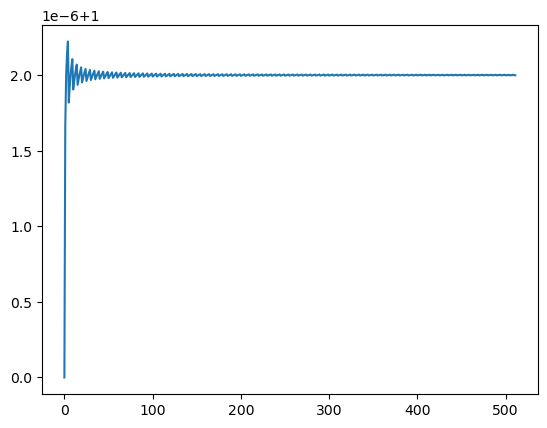

In [169]:
plt.plot (freqsd/freqs)

In [170]:
delta = signal_not_drifted-sigb
delta.std(), signal_not_drifted.std()

(0.010964855810241909, 11228.01117497287)

In [171]:
delta = signal_drifted-sigbd
delta.std(), signal_drifted.std()

(14.4074717076851, 11228.003211647725)

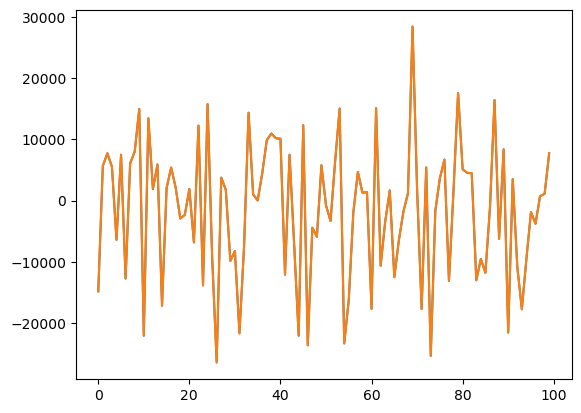

In [172]:
plt.plot(signal_drifted[-100:])
plt.plot(sigbd[-100:])

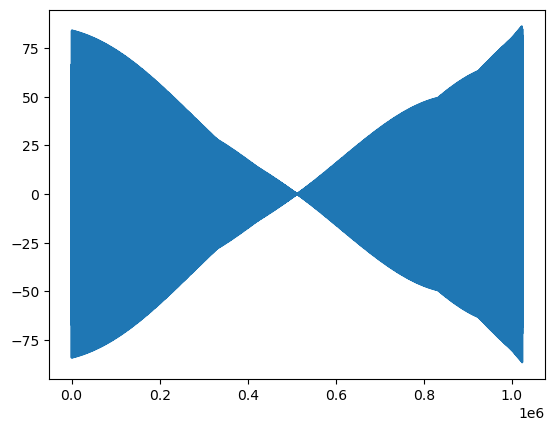

In [173]:
plt.plot(delta)

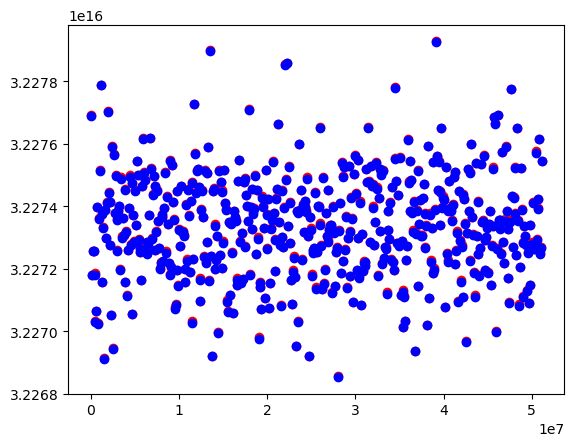

In [174]:
plt.plot(freqs,pwrs,'ro')
plt.plot(freqs,pwrsd,'bo')

In [223]:
# Read the CSV file into a NumPy array
#data = np.genfromtxt("data/240611/25mhz_240611_153549.csv", delimiter=',')[:,4]
data = np.genfromtxt("data/240611/25mhz_p2k_240611_154921.csv", delimiter=',')[:,4]

In [224]:
sampling_rate = 1/4e-009
print(sampling_rate/1e6)

249.99999999999997


In [225]:
freqs, pwrs, df, sigb = get_peaks(data,4, fmax=55e6, sampling_rate=sampling_rate)

[]

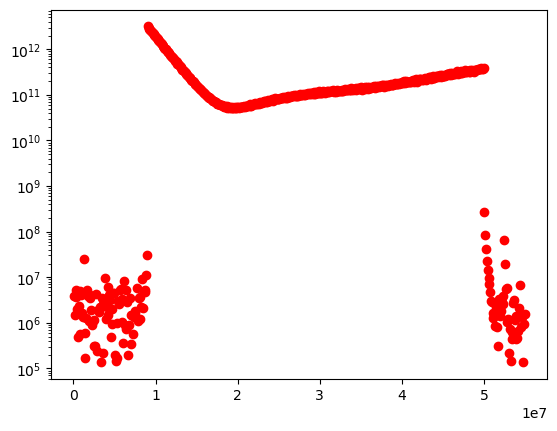

In [226]:
plt.plot(freqs,pwrs,'ro')
#plt.xlim(0.9e6,10e6)
plt.semilogy()

In [227]:
freqs[pwrs>1e8]

array([9050378, 9150382, 9250388, 9350390, 9450395, 9550400, 9650402,
       9750408, 9850412, 9950415, 10050420, 10150425, 10250428, 10350432,
       10450438, 10550440, 10650445, 10750450, 10850452, 10950458,
       11050462, 11150465, 11250470, 11350475, 11450478, 11550482,
       11650488, 11750490, 11850495, 11950500, 12050502, 12150508,
       12250512, 12350515, 12450520, 12550525, 12650528, 12750532,
       12850538, 12950540, 13050545, 13150550, 13250552, 13350558,
       13450562, 13550565, 13650570, 13750575, 13850578, 13950582,
       14050588, 14150590, 14250595, 14350600, 14450602, 14550608,
       14650612, 14750618, 14850620, 14950625, 15050628, 15150632,
       15250638, 15350640, 15450645, 15550650, 15650655, 15750658,
       15850662, 15950668, 16050670, 16150675, 16250680, 16350682,
       16450688, 16550692, 16650695, 16750700, 16850705, 16950708,
       17050712, 17150718, 17250720, 17350725, 17450730, 17550732,
       17650738, 17750742, 17850745, 17950750, 18050

In [228]:
freqs, pwrs, df, sigb = get_peaks(data,20, fbase=9e6+50e3, fmax=50e6, sampling_rate=sampling_rate)

MEAN DRIFT 41.778572947225875


Text(0, 0.5, 'drift ppm')

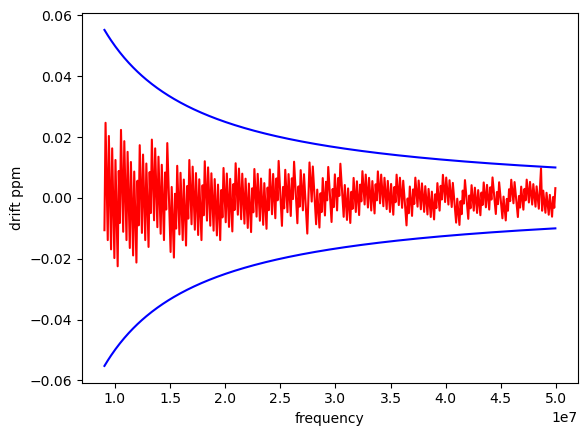

In [229]:
fideal = 9e6+50e3+100e3*np.arange(len(freqs))
resd = (freqs/fideal-1)*1e6
print ("MEAN DRIFT", resd.mean())
plt.plot(fideal, resd-resd.mean() ,'r')
plt.plot(fideal, (df/fideal)*1e6 ,'b')
plt.plot(fideal, -(df/fideal)*1e6 ,'b')
plt.xlabel('frequency')
plt.ylabel('drift ppm')

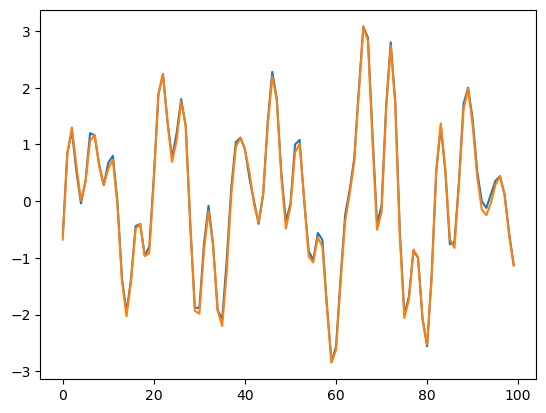

In [235]:
plt.plot(data[:100])
plt.plot(sigb[:100])

In [230]:
diff = data-sigb
diff.std(), data.std()

(0.0679487811935911, 1.2061504397970586)

(array([    1,     1,     3,     3,     3,    10,    18,    15,    32,
           46,    67,    96,   149,   175,   227,   275,   320,   421,
          489,   610,   767,   978,  1357,  1861,  2478,  3264,  4444,
         6150,  8413, 11321, 15692, 21615, 29620, 40652, 55576, 75880,
        102622, 136814, 182605, 238432, 308232, 393549, 490799, 604648,
        729478, 863931, 1002665, 1142859, 1271133, 1382138, 1470141,
        1524472, 1532808, 1503976, 1443211, 1345458, 1219604, 1082828,
        937164, 794571, 656912, 535323, 427155, 337319, 261401, 200017,
        152259, 114237, 84885, 63249, 46532, 34076, 24885, 18555, 13770,
        10086,  7643,  5863,  4474,  3471,  2703,  2073,  1588,  1194,
          901,   683,   530,   380,   243,   169,    91,    72,    46,
           18,    13,     6,     5,     2,     2,     2]),
 array([   -0,    -0,    -0,    -0,    -0,    -0,    -0,    -0,    -0,
           -0,    -0,    -0,    -0,    -0,    -0,    -0,    -0,    -0,
           -0,  

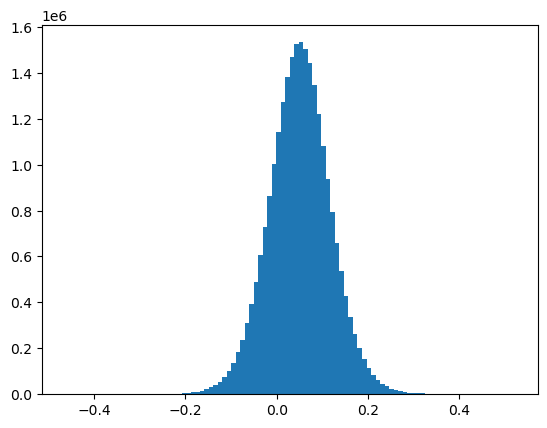

In [231]:
plt.hist(diff,bins=100)

In [232]:
diffPk = np.abs(np.fft.rfft(diff)**2)
dataPk = np.abs(np.fft.rfft(data)**2)
resf = 1/(len(diff)/sampling_rate)*np.arange(len(diffPk))


[]

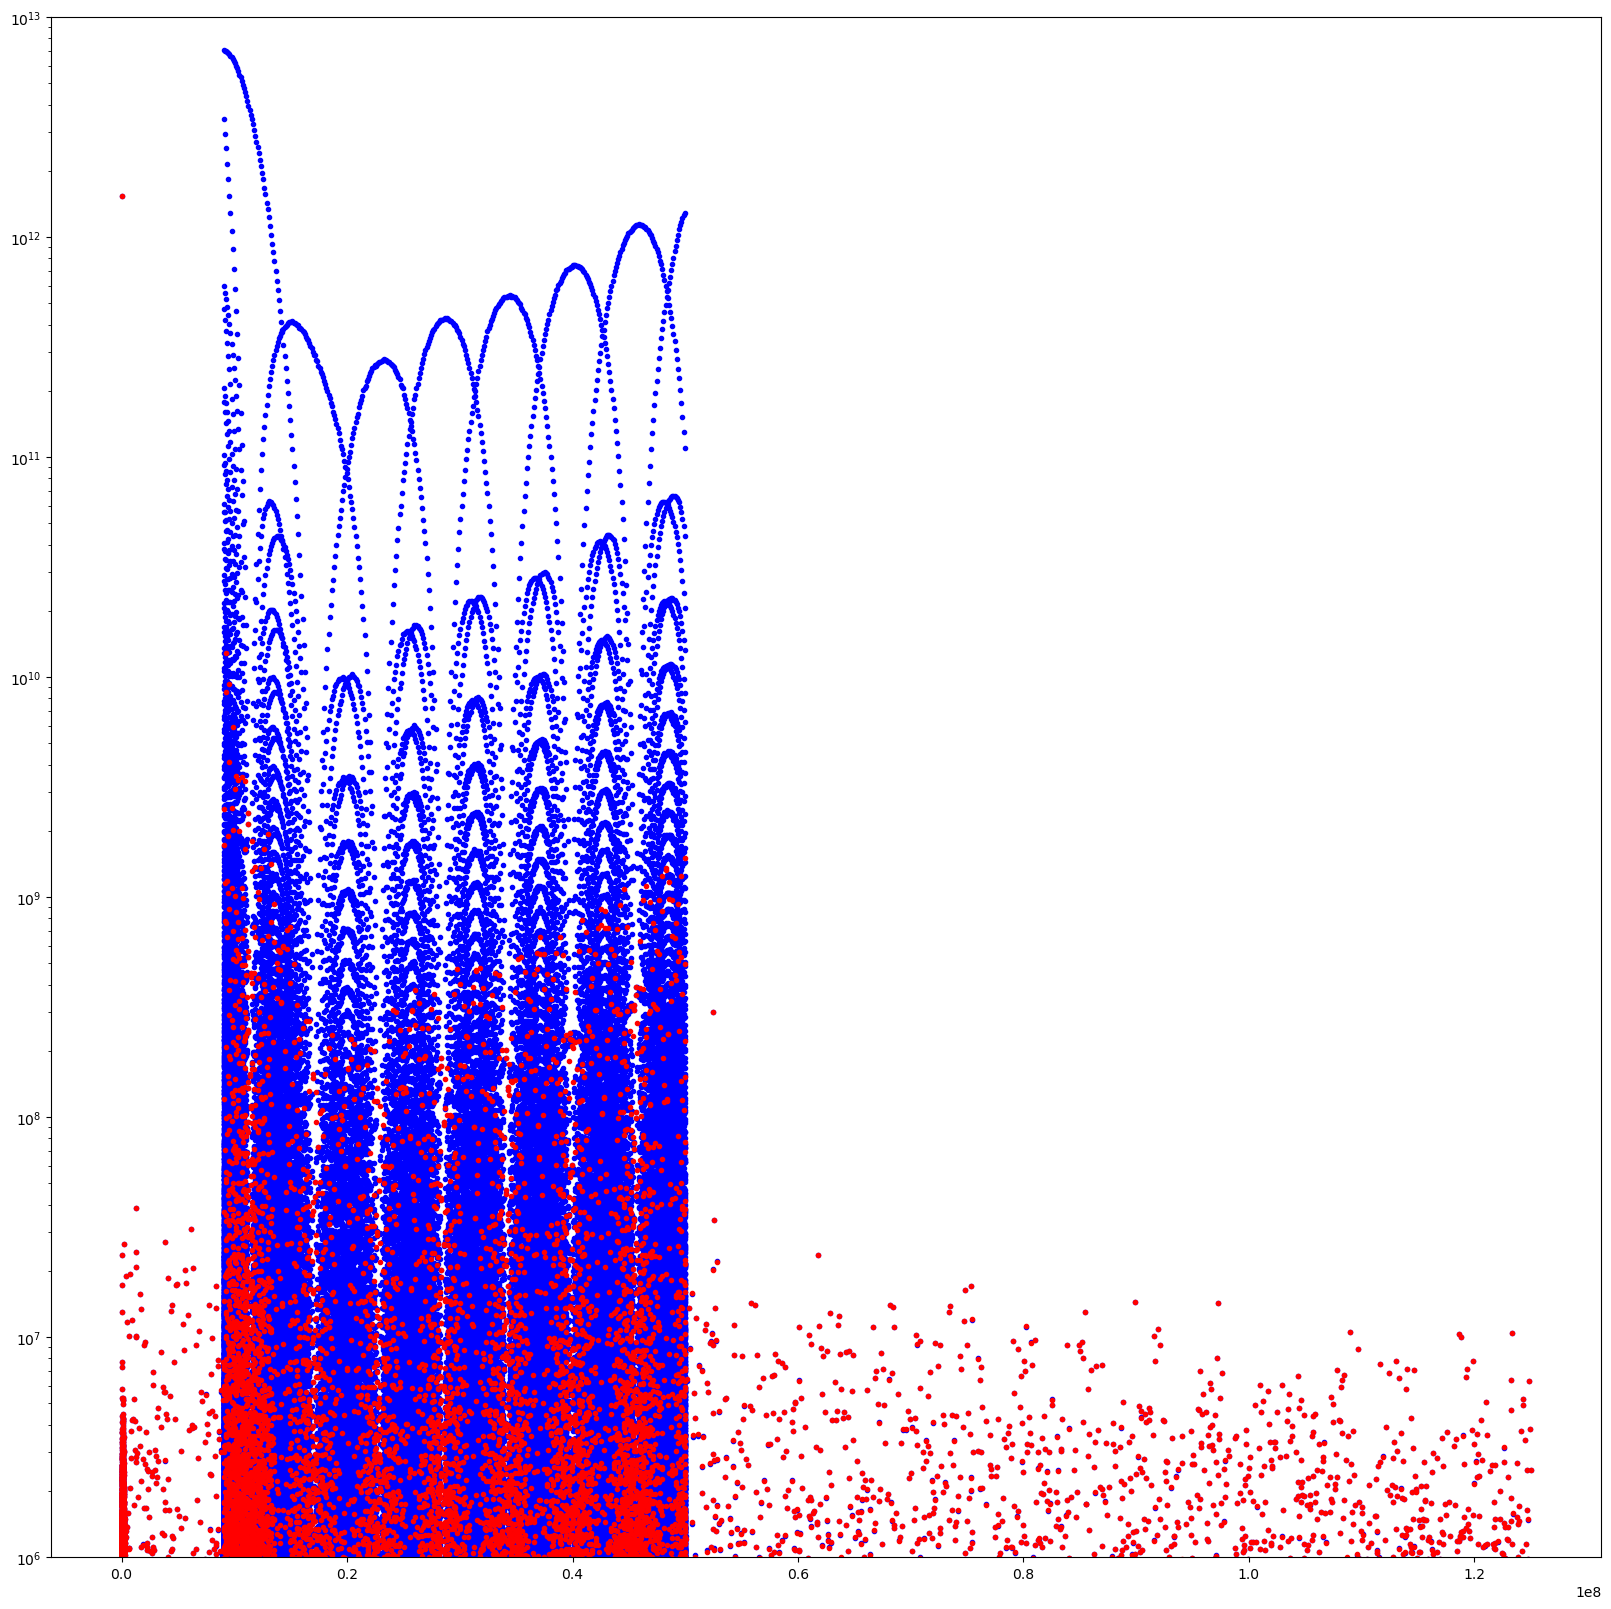

In [221]:
plt.figure(figsize=(20,20))
plt.plot(resf,dataPk,'b.')
plt.plot(resf,diffPk,'r.')
plt.ylim(1e6,1e13)
plt.semilogy()